<a href="https://colab.research.google.com/github/SU-sumico/dlj/blob/main/5_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

目的
* セマンティック セグメンテーションを行う。
* ネコ画像とマスク画像がセットとなったデータセットを用いて学習し、領域単位でネコと背景を分類する。

インストール
* Albumentations: https://albumentations.ai/
* Albumentationsはデータ拡張用ライブラリです。
* ライブラリのインストールは pip install albumentations もしくはgitリポジトリから直接パッケージをインストール pip install -U git+https://github.com/albu/albumentations
* GitHub Packagesからパッケージをインストールし、そのパッケージを自分のプロジェクトの依存関係として使うことができます。

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-j3lc4ae8
  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-j3lc4ae8
  Resolved https://github.com/albu/albumentations to commit c70e664e060bfd7463c20674927aed217f72d437
  Preparing metadata (setup.py) ... done


インストール
* PytorchではSegmentationを簡易に利用できるオープンソース"Segmentation-Models-Pytorch"(SMP)があります。
* このライブラリを用いることで様々なアーキテクチャ(Unetなど)や、バックボーン(VGG, ResNetなど)のSegmentationモデルを簡易に実装できます。
* 参考: https://note-tech.com/python_segmentation/

In [ ]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=9fe3a0eca07ac615fe2615a2900dfb55140b03c84340bebe97b401ee3041c630
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=a2c596961b0e87d9834033b84070aa445abebc48d04bc9ad98b3cde3d88c9261
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
!pip install opencv-python-headless==4.1.2.30

ERROR: Could not find a version that satisfies the requirement opencv-python-headless==4.1.2.30 (from versions: 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.59, 3.4.17.61, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.42, 4.4.0.44, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.58, 4.5.4.60, 4.5.5.62, 4.5.5.64, 4.6.0.66, 4.7.0.68, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78)
ERROR: No matching distribution found for opencv-python-headless==4.1.2.30


In [ ]:
# ライブラリをインポート
import glob
import cv2
import numpy as np
import os

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils.metrics

import albumentations as albu
import matplotlib.pyplot as plt

ネコ画像とマスク画像を並べて表示させるための関数を設定
* 複数の画像を並べて表示するために、以下の関数を宣言します。
* 参考: https://qiita.com/nigo1973/items/e5722c9e859343427293

for文にenumerate()関数を使ってリスト等の要素とインデックスを取得
* for文(for in)とは繰り返し処理であり、特定の条件が満たされるまで同じ数のコードを何度も実行することができます。
* enumerate()関数とは、リストを反復処理しているときに要素のインデックス番号を取得することができます。
* 参考: https://qiita.com/TP-faure/items/ea62178d7c9deb86a433

In [ ]:
# 画像表示
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

Albumentationsのaugmentation: https://qiita.com/kurilab/items/b69e1be8d0224ae139ad

albu.HorizontalFlip
* HorizontalFlip（左右反転）を適用
* y軸を中心に水平に反転

albu.ShiftScaleRotate
* ランダムにアフィン変換を適用する（平行移動、拡大縮小、回転）
* アフィン変換: https://imagingsolution.net/imaging/affine-transformation/

albu.PadIfNeeded
* 所望の解像度にするために画像端をパディングする

albu.RandomCrop
* ランダムに切り取る

albu.IAAAdditiveGaussianNoise
* Add gaussian noise to the input image.入力画像にガウシアンノイズを付与
* IAAAdditiveGaussianNoise: https://albumentations.ai/docs/api_reference/imgaug/transforms/
* ガウシアンノイズ(Gaussian Noise)とは、正規分布（ガウス分布）と等しい確率密度関数を持つノイズのことです。
* 参考: https://tecsingularity.com/opencv/gaussnoise/

albu.IAAPerspective
* Perform a random four point perspective transform of the input.
* ランダム4点透視変換 (IAAPerspective)
* 透視変換とは正方形を任意の四角形に変形する一次変換のことです。
* 参考: https://albumentations.ai/docs/api_reference/imgaug/transforms/

albu.OneOf
* １つの画像操作だけをまとめる

albu.CLAHE
* コントラスト制限適応型ヒストグラム均等化

albu.RandomBrightness
* ランダムに明るさを変える

albu.RandomGamma
* ランダムにガンマ変換をかける

albu.IAASharpen
* Sharpen the input image and overlays the result with the original image.画像を先鋭化
* 参考: https://qiita.com/Takayoshi_Makabe/items/79c8a5ba692aa94043f7

albu.Blur
* ランダムサイズのカーネルでぼかす

albu.MotionBlur
* ランダムなカーネルサイズでモーションブラー(ボックスフィルタ)をかける

albu.RandomContrast
* ランダムにコントラストを変える

albu.HueSaturationValue
* ランダムに色相、彩度、輝度を変える

albu.Compose
* 一連の画像操作をまとめる

In [ ]:
# データ拡張
def get_training_augmentation():
    IMAGE_SIZE = 256
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, always_apply=True, border_mode=0),
        albu.RandomCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

テンソル化
* テンソルの基礎: https://www.tensorflow.org/guide/tensor?hl=ja

**kwargs = keyword argumentsの略
* **が記述されている関数のプログラムが可変長引数です。可変長引数とは関数の引数の個数を指定せずに引数を渡す方法です。
* 引数名に ** を付けると複数のキーワード引数を 1 つの辞書として受け取るようになります。
* 例: def f(x,**kwargs): https://rinatz.github.io/python-book/ch02-02-functions/
* 参考: https://di-acc2.com/programming/python/20133/#index_id0

Tensorを扱う際transposeはよく使われる関数
* imagenetの学習済みモデルを部分的に使うので、その正規化処理や、画像の「高さ,幅,CH」を「CH,高さ,幅」の入れ替えを行います。
* 変換無しが transpose(0, 1, 2) で、軸ナンバーは、チャンネル軸(0), x軸(1), y軸(2)です。
* 参考：https://qiita.com/jun40vn/items/3b4d53f40e160b777a5a

.astype('float32')
* float へとデータ型を変換

albu.Lambda
* 画像データの拡張処理
* 参考：https://qiita.com/nigo1973/items/1d7495a963c23c97189c
* 参考：https://qiita.com/nigo1973/items/c62578fccc7230ba48f8

浮動小数点数の形式
* 参考: https://medium-company.com/%E6%B5%AE%E5%8B%95%E5%B0%8F%E6%95%B0%E7%82%B9%E6%95%B0/

In [ ]:
# テンソル化
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32') # float32は32ビットの浮動小数点数

# 前処理
def get_preprocessing(preprocessing_fn):
    _transform = [
            albu.Lambda(image=preprocessing_fn),
            albu.Lambda(image=to_tensor, mask=to_tensor),
        ]
    return albu.Compose(_transform)

BaseDatasetを継承してDatasetを作ります。
* Datasetクラス: https://zenn.dev/na7na/articles/3e2ef5e0f1a9bd
* BaseDataset: https://mmengine.readthedocs.io/en/latest/advanced_tutorials/basedataset.html

def __init__(self)
* 概念: https://kanda-it-school-kensyu.com/python-basic-contents/pbc_ch03/pbc_0303/
* 「__init__」は、最初にオブジェクトを作るときに呼び出される特殊な関数で「コンストラクタ（constructor）」と呼ばれます。コンストラクタは、オブジェクトの状態を、最初の状態にするときの処理をするのに使います。
* コンストラクタ(__init__)では、生データの格納場所を渡します。
* __getitem__メソッドでは、コンストラクタで定義したディレクトリからデータを1つずつ取得し、必要な処理を適用した後、データセットを返します。
* __len__メソッドでは、コンストラクタで指定した生データの長さを取得します。
* 参考: https://note-tech.com/python_segmentation/

 x for {変数} in {イテラブル}
 * イテラブルとは、forで繰り返し可能なオブジェクトです。
 * 一番最初に書かれているｘはそのあとの変数に依存させることもできますし、独立させることもできます。
 * 参考: https://www.12-technology.com/2022/01/python1forif.html

np.stack: https://numpy.org/doc/stable/reference/generated/numpy.stack.html
* 新たな軸に沿って配列を積み重ねる（=stackする）イメージ: https://it-mayura.com/python/pn007/
* numpy.stack()で新たな軸（次元）に沿って結合: https://note.nkmk.me/python-numpy-concatenate-stack-block/
* np.stack(arrays, axis=0, out=None): https://www.headboost.jp/numpy-stack/
* axis=-1とすると最後の軸が指定される。
* numpyのaxis(軸): https://qiita.com/konitech913/items/864b8d6348fe6bd2019c
* 参考: https://teratail.com/questions/163385

In [ ]:
# データセット
class Dataset(BaseDataset):
    CLASSES = ['background', 'cat']
    def __init__(
            self,
            images_dir, # 画像のPath
            masks_dir, # マスク画像のPath
            classes=None, # 推論対象のクラス
            augmentation=None, # augmentation用関数
            preprocessing=None, # 前処理用関数
    ):
        self.ids = os.listdir(images_dir) # listdir関数でファイル・ディレクトリの一覧を取得
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids] # os.path.join()でパスを結合
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks/マスク上で文字列名をクラス値に変換
        self.class_values = [classes.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # mask/学習対象のクラス('cat')のみを抽出
        mask = cv2.imread(self.masks_fps[i], 0)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

今回はエンコーダーにresnet34、デコーダーにUNetを選びます。
* smp.Unet: https://github.com/qubvel/segmentation_models.pytorch

In [ ]:
# モデルを宣言
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['cat']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'
DECODER = 'unet'
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)
model = model.to("cuda")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 60.5MB/s]


前回作ったデータはtrain、valフォルダに分けたので、それを読み込みます。

smp.encoders.get_preprocessing_fn: https://github.com/qubvel/segmentation_models.pytorch
* smp.encoders.get_preprocessing_fnで各Encoderが学習したときと同じ前処理を実施してくれる関数を呼び出します。

Pytorchを使用して**Dataset**と**Dataloader**を作成することでミニバッチ学習のためのデータを作成します。

PyTorchの**Dataset**
* PytorchのDatasetは、特徴量行列（ラベル以外のデータ）XとラベルyをTensorDatasetというクラスに渡して、特徴量行列とラベルを一つのデータベース的なものにまとめる働きをします。
* PyTorchのDatasetは、データの取得や前処理を行ってくれる便利なクラスです。
* 参考: https://dreamer-uma.com/pytorch-dataset/

PyTorchの**DataLoader**
* PytorchのDataLoaderは、Dataset からサンプルを取得して、ミニバッチを作成するクラスです。基本的には、サンプルを取得する Dataset とバッチサイズを指定して作成します。
* 参考: https://pystyle.info/pytorch-dataloader/

In [ ]:
train_dir = '/content/drive/MyDrive/Deep learning/cat_segmentation/train'
val_dir = '/content/drive/MyDrive/Deep learning/cat_segmentation/val'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# Train,Validationのデータセットを作成
train_dataset = Dataset(
    os.path.join(train_dir, 'images'),
    os.path.join(train_dir, 'masks'),
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['cat'],
)
valid_dataset = Dataset(
    os.path.join(val_dir, 'images'),
    os.path.join(val_dir, 'masks'),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['cat'],
)
# データローダーを作成
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/alb

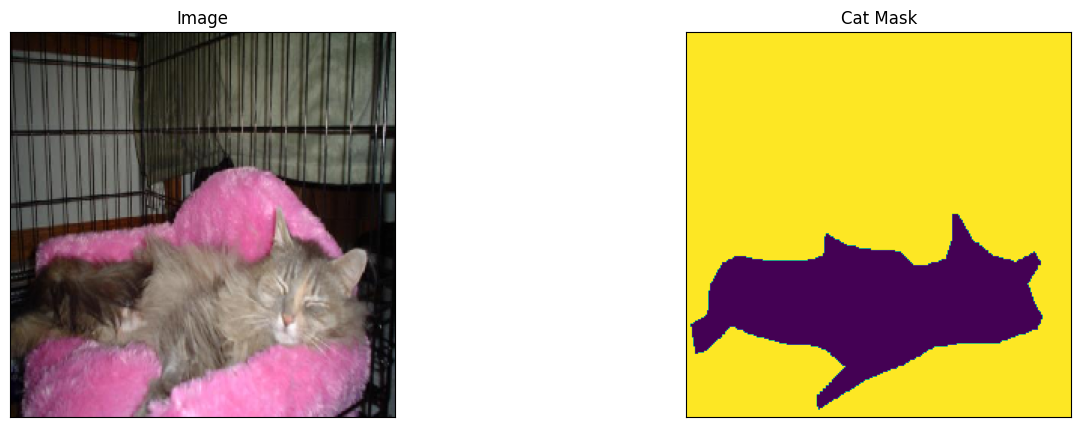

In [ ]:
# データ確認
dataset = Dataset(os.path.join(train_dir, 'images'), os.path.join(train_dir, 'masks'), classes=['cat'])

image, mask = dataset[5] # get some sample
visualize(
    image=image,
    cat_mask=mask.squeeze(),
)

学習の評価指標(metrics)、損失関数(loss)、最適化関数(optimizer)を決めます。

In [ ]:
# 評価指標
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]
# 損失関数
loss = smp.utils.losses.DiceLoss()
# 最適化関数
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.001),
])

smp.utils.train
* SMPに用意されているシンプルなループ関数(Train&Validation用)
* 参考: https://qiita.com/tchih11/items/6e143dc639e3454cf577
* 参考: https://note-tech.com/python_segmentation/
* ライブラリに1エポック学習するものが用意されているのでそれを使います。
* TrainEpochとValidEpochで学習/検証時の設定を行い、for文で学習を実行します。

In [ ]:
# 1Epoch訓練用
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

学習の実行およびモデルの保存
* 事前に作成したDataloaderを入れてfor文で回します。
* 「for i in range(1,400):」とは「1から400までの範囲の中でiの値を変えながらくり返す」
* 今回は40回分学習します。25Epoch目に学習率を変更しています。
* 参考: https://qiita.com/tchih11/items/6e143dc639e3454cf577

 except Exception as e
 * 受け取った例外の中身が知りたい場合は、exception の代わりに except Exception as e: と記述することで、例外のメッセージを取得することが出来ます。

In [ ]:
# 学習 40Epoch 25Epochで学習率を下げる
max_score = 0
for i in range(0, 40):

    print('\nEpoch: {}'.format(i))
    try:
        train_logs = train_epoch.run(train_loader)
        val_logs = valid_epoch.run(valid_loader)
    except Exception as e:
        print(e)

    # do something (save model, change lr, etc.)/IoUスコアが最高値が更新されればモデルを保存
    if max_score < val_logs['iou_score']:
        max_score = val_logs['iou_score']
        torch.save(model, f'{DECODER}_{ENCODER}.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-4 # 0.0001
        print('Decrease decoder learning rate to 1e-4!')


Epoch: 0
valid: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s, dice_loss - 0.239, iou_score - 0.647]
Model saved!

Epoch: 1
valid: 100%|██████████| 20/20 [00:00<00:00, 50.32it/s, dice_loss - 0.2216, iou_score - 0.6536]
Model saved!

Epoch: 2
valid: 100%|██████████| 20/20 [00:00<00:00, 51.38it/s, dice_loss - 0.2123, iou_score - 0.6623]
Model saved!

Epoch: 3
valid: 100%|██████████| 20/20 [00:00<00:00, 52.13it/s, dice_loss - 0.2143, iou_score - 0.6725]
Model saved!

Epoch: 4
valid: 100%|██████████| 20/20 [00:00<00:00, 43.56it/s, dice_loss - 0.2596, iou_score - 0.6063]

Epoch: 5
valid: 100%|██████████| 20/20 [00:00<00:00, 49.73it/s, dice_loss - 0.2057, iou_score - 0.679]
Model saved!

Epoch: 6
valid: 100%|██████████| 20/20 [00:00<00:00, 49.89it/s, dice_loss - 0.184, iou_score - 0.7155]
Model saved!

Epoch: 7
valid: 100%|██████████| 20/20 [00:00<00:00, 50.56it/s, dice_loss - 0.2015, iou_score - 0.6916]

Epoch: 8
valid: 100%|██████████| 20/20 [00:00<00:00, 43.20it/s, dice_loss - 0.2017, i

学習したモデルを使って、どのようにセグメンテーションできるか確認します。

numpy.zeros(shape, dtype = None, order = ‘C’)
* np.zerosは、すべての要素を0とする配列を生成するものです。

numpy.where()
* numpy.where(condition, x, y)は、第一引数conditionの真の要素を第二引数x、偽の要素を第三引数yに置き換えた配列ndarrayを返します。

In [ ]:
# 画像読み込み
val_files = glob.glob('/content/drive/MyDrive/Deep learning/cat_segmentation/val/images/*')
f = val_files[5]
image_src = cv2.imread(f)
image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)

# 前処理
image = preprocessing_fn(image_src)
image = image.transpose(2, 0, 1).astype('float32')

# モデルで推論
image=torch.from_numpy(image).to(DEVICE).unsqueeze(0)
predict = model(image)
predict = predict.detach().cpu().numpy()[0].reshape((256,256))

# 0.5以上を1とする
predict_img = np.zeros([256,256]).astype(np.int8)
predict_img = np.where(predict>0.5, 1, predict_img)

AIが予測して結果が取得できたので表示します。

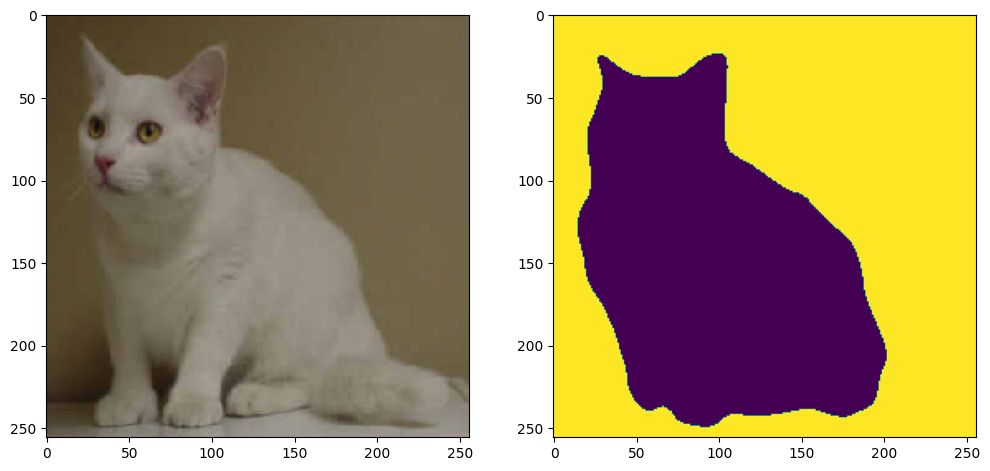

In [ ]:
# 横並び
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(image_src)
ax2.imshow(predict_img)

評価指標: https://book.st-hakky.com/data-science/intersection-over-union/
* Intersection over Union (IoU): オーバーラップ率): 0~1の値をとり、0のとき矩形は全く重なっていない状態を、1のとき矩形が完全に重なった状態であることを表しています。